In [1]:
import torch
import torchvision
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets,transforms,utils
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split,Dataset
from tqdm.notebook import tqdm as tqdm
import torch.utils.data as data
import torchvision.models as models
import seaborn as sns
import torch.quantization as quantization
import warnings
import pickle
import cv2
warnings.filterwarnings('ignore')
sns.set_theme()
import torchvision.transforms as transforms
from torchvision import datasets, transforms
%matplotlib inline
plt.ion() #Turn interactive mode on.
torch.manual_seed(34)
from torch.utils.data import Dataset,DataLoader
from torchsummary import summary
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import multilabel_confusion_matrix
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import time
import tensorflow as tf

# **Data Preparation and Preprocessing**

In [2]:
import zipfile
import os

# Define the path to the zip file and the extraction directory
zip_path = '/content/drive/MyDrive/Expanded_dataset.zip'
extract_dir = '/content/Expanded_dataset'

# Create extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Unzip the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)


In [3]:
import zipfile
import os

# Define the path to the zip file and the extraction directory
zip_path = '/content/drive/MyDrive/VisDrone2019-DET-train.zip'
extract_dir = '/content/VisDrone_train'

# Create extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Unzip the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)


In [ ]:
import zipfile
import os

# Define the path to the zip file and the extraction directory
zip_path = '/content/drive/MyDrive/VisDrone2019-DET-val.zip'
extract_dir = '/content/VisDrone_val'

# Create extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Unzip the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)


In [4]:
def extract_classes_from_annotations(annotations_dir):
    classes = set()
    for annotation_file in os.listdir(annotations_dir):
        if annotation_file.endswith('.txt'):
            with open(os.path.join(annotations_dir, annotation_file), 'r') as file:
                for line in file:
                    parts = line.strip().split(',')
                    if len(parts) > 5:  # assuming class label is in the 6th position
                        class_label = parts[5]
                        classes.add(class_label)
    return classes

In [5]:
# Extract classes from both datasets
visdrone_annotations_dir = '/content/VisDrone_train/VisDrone2019-DET-train/annotations'
expanded_annotations_dir = '/content/Expanded_dataset/annotations'


In [6]:
visdrone_classes = extract_classes_from_annotations(visdrone_annotations_dir)
expanded_classes = extract_classes_from_annotations(expanded_annotations_dir)


In [7]:
# Find common classes
common_classes = visdrone_classes.intersection(expanded_classes)
common_classes = list(common_classes)[:]  # Select 5 common classes
print("Common Classes:", common_classes)

Common Classes: ['3', '9', '6', '10', '8', '11', '1', '0', '2', '7', '4', '5']


In [8]:
common_classes = [1, 2, 3, 4, 5]
print(common_classes)
print(type(common_classes))

[1, 2, 3, 4, 5]
<class 'list'>


In [9]:
import shutil

def create_one_vs_rest_datasets(common_classes, annotations_dir, images_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    for class_label in common_classes:
        class_dir = os.path.join(output_dir, str(class_label))
        os.makedirs(class_dir, exist_ok=True)
        os.makedirs(os.path.join(class_dir, 'images'), exist_ok=True)
        os.makedirs(os.path.join(class_dir, 'annotations'), exist_ok=True)

        for annotation_file in os.listdir(annotations_dir):
            if annotation_file.endswith('.txt'):
                with open(os.path.join(annotations_dir, annotation_file), 'r') as file:
                    annotations = file.readlines()

                annotations_modified = []
                for line in annotations:
                    parts = line.strip().split(',')
                    if len(parts) > 5:
                        # Modify the class label to 1 for the target class and 0 for others
                        original_class = parts[5]
                        new_class = '1' if original_class == str(class_label) else '0'
                        parts[5] = new_class
                        annotations_modified.append(','.join(parts))

                if annotations_modified:
                    # Copy the image file
                    image_file = os.path.join(images_dir, annotation_file.replace('.txt', '.jpg'))
                    if os.path.exists(image_file):
                        shutil.copy(image_file, os.path.join(class_dir, 'images', os.path.basename(image_file)))

                    # Write the modified annotations to the output directory
                    with open(os.path.join(class_dir, 'annotations', annotation_file), 'w') as out_file:
                        out_file.write('\n'.join(annotations_modified) + '\n')


In [10]:
output_dir = '/content/one_vs_rest_datasets/visdrone'
create_one_vs_rest_datasets(common_classes, visdrone_annotations_dir, '/content/VisDrone_train/VisDrone2019-DET-train/images', output_dir)


In [11]:
output_dir = '/content/one_vs_rest_datasets/expanded_dataset'
create_one_vs_rest_datasets(common_classes, expanded_annotations_dir, '/content/Expanded_dataset/images', output_dir)

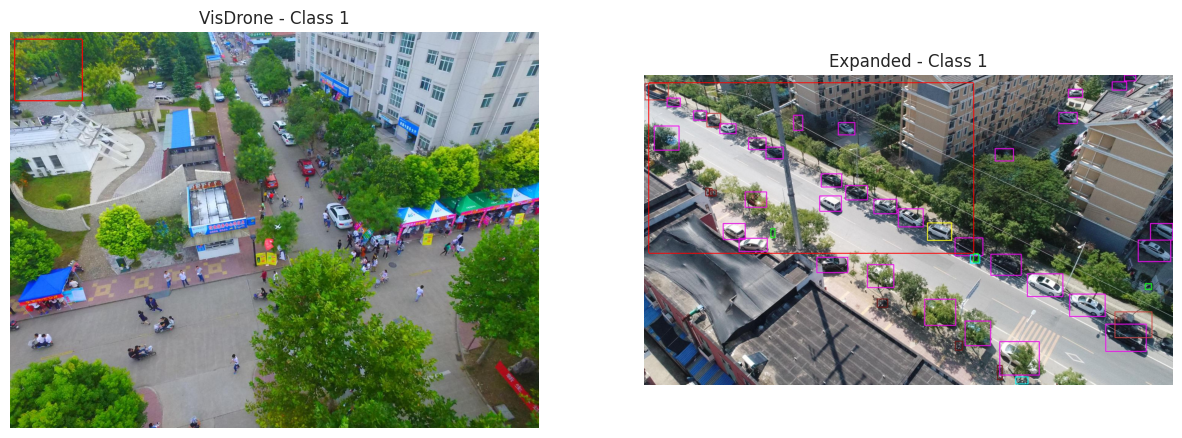

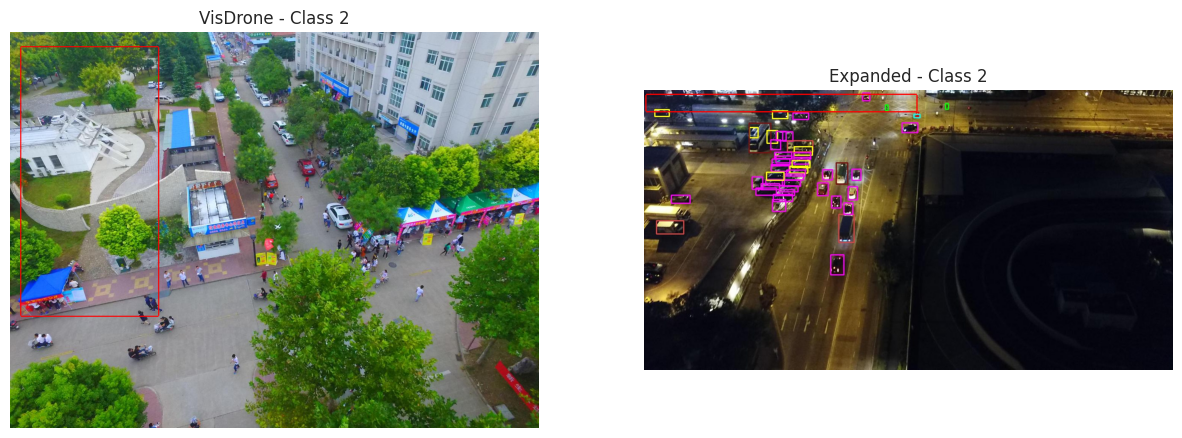

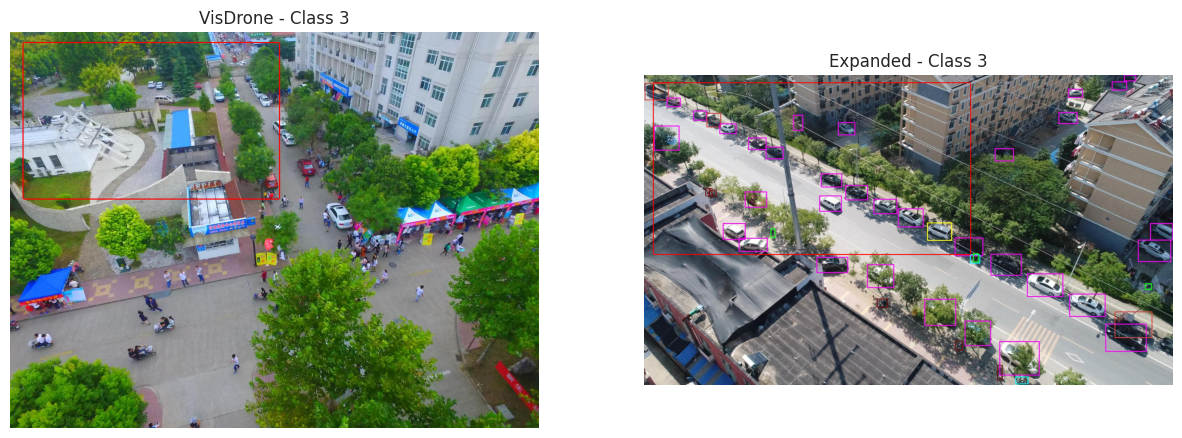

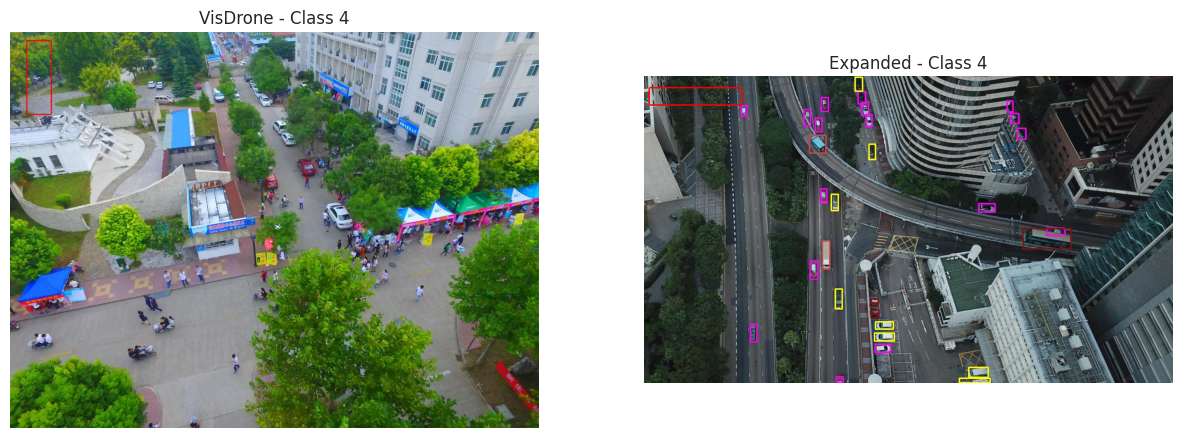

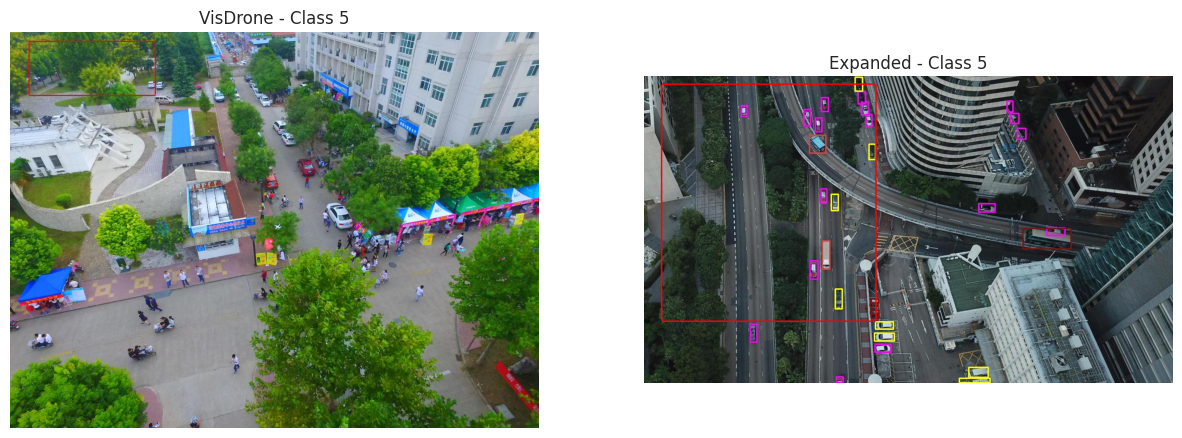

In [23]:
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

def find_and_plot_common_class_images(common_classes, visdrone_dir, expanded_dir):
    for class_label in common_classes:
        visdrone_image_path, visdrone_bbox = find_image_with_class(visdrone_dir, class_label)
        expanded_image_path, expanded_bbox = find_image_with_class(expanded_dir, class_label)

        if visdrone_image_path and expanded_image_path:
            visdrone_image = Image.open(visdrone_image_path)
            expanded_image = Image.open(expanded_image_path)

            visdrone_image = draw_bounding_box(visdrone_image, visdrone_bbox)
            expanded_image = draw_bounding_box(expanded_image, expanded_bbox)

            plot_images_side_by_side(visdrone_image, expanded_image, class_label)
        else:
            print(f"No image found for class {class_label} in one of the datasets.")

def find_image_with_class(dataset_dir, class_label):
    image_dir = os.path.join(dataset_dir, str(class_label), 'images')
    annotation_dir = os.path.join(dataset_dir, str(class_label), 'annotations')

    for annotation_file in os.listdir(annotation_dir):
        if annotation_file.endswith('.txt'):
            with open(os.path.join(annotation_dir, annotation_file), 'r') as file:
                annotations = file.readlines()

            for line in annotations:
                parts = line.strip().split(',')
                if len(parts) > 5 and parts[5] == str(1):
                    bbox = [int(parts[0]), int(parts[1]), int(parts[2]), int(parts[3])]
                    image_path = os.path.join(image_dir, annotation_file.replace('.txt', '.jpg'))
                    # print(image_path)
                    if os.path.exists(image_path):
                        return image_path, bbox

    return None, None

def draw_bounding_box(image, bbox):
    draw = ImageDraw.Draw(image)
    draw.rectangle(bbox, outline="red", width=3)
    return image

def plot_images_side_by_side(image1, image2, class_label):
    fig, axs = plt.subplots(1, 2, figsize=(15, 7))

    axs[0].imshow(image1)
    axs[0].set_title(f'VisDrone - Class {class_label}')
    axs[0].axis('off')

    axs[1].imshow(image2)
    axs[1].set_title(f'Expanded - Class {class_label}')
    axs[1].axis('off')

    plt.show()

visdrone_dir = '/content/one_vs_rest_datasets/visdrone'
expanded_dir = '/content/one_vs_rest_datasets/expanded_dataset'

find_and_plot_common_class_images(common_classes, visdrone_dir, expanded_dir)


In [13]:
import os

def count_class_samples(common_classes, annotations_dir):
    # Dictionary to hold the count of samples for each class
    class_counts = {str(class_label): 0 for class_label in common_classes}

    for annotation_file in os.listdir(annotations_dir):
        if annotation_file.endswith('.txt'):
            with open(os.path.join(annotations_dir, annotation_file), 'r') as file:
                annotations = file.readlines()

            found_classes = set()
            for line in annotations:
                parts = line.strip().split(',')
                if len(parts) > 5:
                    class_label = parts[5]
                    found_classes.add(class_label)

            for class_label in found_classes:
                if class_label in class_counts:
                    class_counts[class_label] += 1

    return class_counts

In [14]:
class_counts = count_class_samples(common_classes, '/content/Expanded_dataset/annotations')
print(class_counts)

{'1': 929, '2': 593, '3': 269, '4': 1215, '5': 848}


In [21]:
class_counts = count_class_samples(common_classes, '/content/VisDrone_train/VisDrone2019-DET-train/annotations')
print(class_counts)

{'1': 5366, '2': 3947, '3': 2755, '4': 6133, '5': 4948}


# **MobileNetV2 Train:Expanded Val:Expanded**

In [ ]:
import tensorflow as tf

def load_data(data_dir, target_size=(224, 224), batch_size=32):
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2  # 20% validation split
    )

    train_generator = datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',  # binary classification
        subset='training'
    )

    val_generator = datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        subset='validation'
    )

    return train_generator, val_generator


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import BinaryCrossentropy

def create_model(input_shape=(224, 224, 3)):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model weights

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1, activation='sigmoid')  # Binary classification (sigmoid activation)
    ])

    model.compile(optimizer=RMSprop(learning_rate=0.001),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model

In [ ]:
# Example function to train a model for a specific class
def train_model_for_class(class_label, data_dir):
    train_generator, val_generator = load_data(os.path.join(data_dir, str(class_label)))

    model = create_model()

    # Train the model
    history = model.fit(
        train_generator,
        epochs=10,  # adjust as needed
        validation_data=val_generator
    )

    return model, history

In [ ]:
data_dir = '/content/one_vs_rest_datasets/expanded_dataset'

trained_models = {}

for class_label in common_classes:
    print(f"Training model for class {class_label}...")
    model, history = train_model_for_class(class_label, data_dir)
    trained_models[class_label] = model

    # Optionally, you can save the trained model
    model.save(f'MobileNetV2_trEx_valEx_class_{class_label}.h5')
    print(f"Model for class {class_label} trained and saved.")

Training model for class 1...
Found 1039 images belonging to 2 classes.
Found 259 images belonging to 2 classes.
9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/10
33/33 [==============================] - 20s 428ms/step - loss: 0.0575 - accuracy: 0.9827 - val_loss: 0.0047 - val_accuracy: 1.0000
Epoch 2/10
33/33 [==============================] - 12s 376ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 8.1808e-04 - val_accuracy: 1.0000
Epoch 3/10
33/33 [==============================] - 12s 373ms/step - loss: 3.7621e-04 - accuracy: 1.0000 - val_loss: 1.6082e-04 - val_accuracy: 1.0000
Epoch 4/10
33/33 [==============================] - 12s 366ms/step - loss: 7.8290e-05 - accuracy: 1.0000 - val_loss: 4.1546e-05 - val_accuracy: 1.0000
Epoch 5/10
33/33 [==============================] - 12s 377ms/step - loss: 2.6886e-05 - accuracy: 1.0000 - val_loss: 1.9580e-05 - val_accuracy: 1.0000
Epoch 6/10
33/33 [==============================] - 12s 371ms/step - loss: 1.5053

# **MobileNetV2 Train:Visdrone Val:Visdrone**

In [ ]:
import tensorflow as tf

def load_data(data_dir, target_size=(224, 224), batch_size=32):
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2  # 20% validation split
    )

    train_generator = datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',  # binary classification
        subset='training'
    )

    val_generator = datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        subset='validation'
    )

    return train_generator, val_generator


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import BinaryCrossentropy

def create_model(input_shape=(224, 224, 3)):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model weights

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1, activation='sigmoid')  # Binary classification (sigmoid activation)
    ])

    model.compile(optimizer=RMSprop(learning_rate=0.001),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model

In [ ]:
# Example function to train a model for a specific class
def train_model_for_class(class_label, data_dir):
    train_generator, val_generator = load_data(os.path.join(data_dir, str(class_label)))

    model = create_model()

    # Train the model
    history = model.fit(
        train_generator,
        epochs=5,  # adjust as needed
        validation_data=val_generator
    )

    return model, history

In [ ]:
data_dir = '/content/one_vs_rest_datasets/visdrone'

trained_models = {}

for class_label in common_classes:
    print(f"Training model for class {class_label}...")
    model, history = train_model_for_class(class_label, data_dir)
    trained_models[class_label] = model

    # Optionally, you can save the trained model
    model.save(f'MobileNetV2_trVis_valVis_class_{class_label}.h5')
    print(f"Model for class {class_label} trained and saved.")

Training model for class 1...
Found 5177 images belonging to 2 classes.
Found 1294 images belonging to 2 classes.
Epoch 1/5
162/162 [==============================] - 91s 549ms/step - loss: 0.0199 - accuracy: 0.9934 - val_loss: 3.5208e-05 - val_accuracy: 1.0000
Epoch 2/5
162/162 [==============================] - 63s 389ms/step - loss: 1.0486e-05 - accuracy: 1.0000 - val_loss: 9.9702e-06 - val_accuracy: 1.0000
Epoch 3/5
162/162 [==============================] - 65s 404ms/step - loss: 4.1168e-06 - accuracy: 1.0000 - val_loss: 6.2416e-06 - val_accuracy: 1.0000
Epoch 4/5
162/162 [==============================] - 64s 395ms/step - loss: 2.6449e-06 - accuracy: 1.0000 - val_loss: 4.6643e-06 - val_accuracy: 1.0000
Epoch 5/5
162/162 [==============================] - 62s 385ms/step - loss: 1.9631e-06 - accuracy: 1.0000 - val_loss: 3.7726e-06 - val_accuracy: 1.0000
Model for class 1 trained and saved.
Training model for class 2...
Found 5177 images belonging to 2 classes.
Found 1294 images bel

# **MobileNetV2 Train:Visdrone Val:Expanded**

In [ ]:
def load_training_data(data_dir, target_size=(224, 224), batch_size=32):
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

    train_generator = datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary'  # binary classification
    )

    return train_generator

def load_validation_data(data_dir, target_size=(224, 224), batch_size=32):
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

    val_generator = datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary'
    )

    return val_generator

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import BinaryCrossentropy

def create_model(input_shape=(224, 224, 3)):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model weights

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1, activation='sigmoid')  # Binary classification (sigmoid activation)
    ])

    model.compile(optimizer=RMSprop(learning_rate=0.001),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model


In [ ]:
# Function to train and validate a model for a specific class
def train_and_validate_model_for_class(class_label, train_data_dir, val_data_dir):
    train_generator = load_training_data(os.path.join(train_data_dir, str(class_label)))
    val_generator = load_validation_data(os.path.join(val_data_dir, str(class_label)))

    model = create_model()

    # Train the model
    history = model.fit(
        train_generator,
        epochs=5,
        validation_data=val_generator
    )

    return model, history

In [ ]:
visdrone_data_dir = '/content/one_vs_rest_datasets/visdrone'
expanded_data_dir = '/content/one_vs_rest_datasets/expanded_dataset'

trained_models = {}

for class_label in common_classes:
    print(f"Training and validating model for class {class_label}...")
    model, history = train_and_validate_model_for_class(class_label, visdrone_data_dir, expanded_data_dir)
    trained_models[class_label] = model

    # Optionally, you can save the trained model
    model.save(f'MobileNetV2_trVis_valEx_class_{class_label}.h5')
    print(f"Model for class {class_label} trained and saved.")

Training and validating model for class 1...
Found 6471 images belonging to 2 classes.
Found 1298 images belonging to 2 classes.
9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/5
203/203 [==============================] - 110s 508ms/step - loss: 0.0183 - accuracy: 0.9944 - val_loss: 1.0904e-05 - val_accuracy: 1.0000
Epoch 2/5
203/203 [==============================] - 85s 420ms/step - loss: 7.3324e-06 - accuracy: 1.0000 - val_loss: 3.3038e-06 - val_accuracy: 1.0000
Epoch 3/5
203/203 [==============================] - 94s 461ms/step - loss: 3.3076e-06 - accuracy: 1.0000 - val_loss: 1.9998e-06 - val_accuracy: 1.0000
Epoch 4/5
203/203 [==============================] - 90s 444ms/step - loss: 2.1957e-06 - accuracy: 1.0000 - val_loss: 1.4488e-06 - val_accuracy: 1.0000
Epoch 5/5
203/203 [==============================] - 82s 403ms/step - loss: 1.6555e-06 - accuracy: 1.0000 - val_loss: 1.1424e-06 - val_accuracy: 1.0000
Model for class 1 trained and saved.
Training and v

# **MobileNetV2 Train:Expanded Val:Visdrone**

In [ ]:
def load_training_data(data_dir, target_size=(224, 224), batch_size=32):
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

    train_generator = datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary'  # binary classification
    )

    return train_generator

def load_validation_data(data_dir, target_size=(224, 224), batch_size=32):
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

    val_generator = datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary'
    )

    return val_generator

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import BinaryCrossentropy

def create_model(input_shape=(224, 224, 3)):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model weights

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1, activation='sigmoid')  # Binary classification (sigmoid activation)
    ])

    model.compile(optimizer=RMSprop(learning_rate=0.001),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model


In [ ]:
# Function to train and validate a model for a specific class
def train_and_validate_model_for_class(class_label, train_data_dir, val_data_dir):
    train_generator = load_training_data(os.path.join(train_data_dir, str(class_label)))
    val_generator = load_validation_data(os.path.join(val_data_dir, str(class_label)))

    model = create_model()

    # Train the model
    history = model.fit(
        train_generator,
        epochs=5,
        validation_data=val_generator
    )

    return model, history

In [ ]:
visdrone_data_dir = '/content/one_vs_rest_datasets/visdrone'
expanded_data_dir = '/content/one_vs_rest_datasets/expanded_dataset'

trained_models = {}

for class_label in common_classes:
    print(f"Training and validating model for class {class_label}...")
    model, history = train_and_validate_model_for_class(class_label, expanded_data_dir, visdrone_data_dir)
    trained_models[class_label] = model

    # Optionally, you can save the trained model
    model.save(f'MobileNetV2_trEx_valVis_class_{class_label}.h5')
    print(f"Model for class {class_label} trained and saved.")

Training and validating model for class 1...
Found 1298 images belonging to 2 classes.
Found 6471 images belonging to 2 classes.
Epoch 1/5
41/41 [==============================] - 113s 3s/step - loss: 0.0525 - accuracy: 0.9815 - val_loss: 0.0057 - val_accuracy: 1.0000
Epoch 2/5
41/41 [==============================] - 95s 2s/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 7.6144e-04 - val_accuracy: 1.0000
Epoch 3/5
41/41 [==============================] - 90s 2s/step - loss: 1.5458e-04 - accuracy: 1.0000 - val_loss: 1.4500e-04 - val_accuracy: 1.0000
Epoch 4/5
41/41 [==============================] - 87s 2s/step - loss: 3.0748e-05 - accuracy: 1.0000 - val_loss: 5.8103e-05 - val_accuracy: 1.0000
Epoch 5/5
41/41 [==============================] - 86s 2s/step - loss: 1.3289e-05 - accuracy: 1.0000 - val_loss: 3.6787e-05 - val_accuracy: 1.0000
Model for class 1 trained and saved.
Training and validating model for class 2...
Found 1298 images belonging to 2 classes.
Found 6471 images belon

# **AttentionCNN Train:Expanded Val:Expanded**

In [ ]:
# Define the AttentionBlock and AttentionCNN_v2 as provided
class AttentionBlock(nn.Module):
    def __init__(self, in_channels):
        super(AttentionBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(in_channels // 8, in_channels)
        self.fc2 = nn.Linear(in_channels, in_channels)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y = self.conv(x)
        y = self.relu(y)
        y = self.pool(y)
        y = y.view(y.size(0), -1)
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y)
        return x * y.unsqueeze(2).unsqueeze(3)

class AttentionCNN_v2(nn.Module):
    def __init__(self, flatten_shape=7*7*512, num_classes=2):
        super(AttentionCNN_v2, self).__init__()
        self.flatten_shape = flatten_shape
        self.conv1 = self.convLayer(3, 64, kernel_size=7, stride=2, padding=3)
        self.attention1 = AttentionBlock(64)
        self.conv2 = self.convLayer(64, 128, kernel_size=3, stride=2, padding=1)
        self.attention2 = AttentionBlock(128)
        self.conv3 = self.convLayer(128, 256, kernel_size=3, stride=2, padding=1)
        self.attention3 = AttentionBlock(256)
        self.conv4 = self.convLayer(256, 512, kernel_size=3, stride=2, padding=1)
        self.attention4 = AttentionBlock(512)
        self.conv5 = self.convLayer(512, 512, kernel_size=3, stride=2, padding=1)
        self.fc = nn.Linear(self.flatten_shape, num_classes)

    def convLayer(self, in_planes, out_planes, kernel_size, stride, padding, fl=1):
        if fl:
            return nn.Sequential(
                nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=2, padding=1, groups=in_planes),
                nn.Conv2d(in_planes, out_planes, kernel_size=1),
                nn.BatchNorm2d(out_planes)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(in_channels=in_planes, out_channels=out_planes, kernel_size=kernel_size, padding=padding, stride=stride),
                nn.BatchNorm2d(out_planes)
            )

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.attention1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.attention2(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.attention3(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.attention4(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, transform=None):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        annotation_path = os.path.join(self.annotation_dir, img_name.replace('.jpg', '.txt'))

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        with open(annotation_path, 'r') as file:
            annotation = file.readline().strip().split(',')
            label = int(annotation[5])

        return image, torch.tensor(label, dtype=torch.float32)

In [ ]:
# Function to load and split data
def load_and_split_data(data_dir, batch_size=32, split_ratio=0.2, transform=None):
    image_dir = os.path.join(data_dir, 'images')
    annotation_dir = os.path.join(data_dir, 'annotations')

    if transform is None:
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    dataset = CustomDataset(image_dir, annotation_dir, transform=transform)
    val_size = int(split_ratio * len(dataset))
    train_size = len(dataset) - val_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Function to train the model
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.float().unsqueeze(1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

In [ ]:
# Function to validate the model
def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            val_loss += loss.item()
            predicted = torch.round(torch.sigmoid(outputs)).squeeze(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")


In [ ]:
# Example usage
expanded_data_dir = '/content/one_vs_rest_datasets/expanded_dataset'
batch_size = 32
num_epochs = 10

trained_models = {}

for class_label in common_classes:
    print(f"Training and validating model for class {class_label}...")

    train_loader, val_loader = load_and_split_data(os.path.join(expanded_data_dir, str(class_label)), batch_size=batch_size)

    model = AttentionCNN_v2(num_classes=1).to(device)  # Binary classification
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_model(model, train_loader, criterion, optimizer, num_epochs=num_epochs)
    validate_model(model, val_loader, criterion)

    trained_models[class_label] = model

    # Optionally, save the trained model
    torch.save(model.state_dict(), f'model_class_{class_label}.pth')
    print(f"Model for class {class_label} trained and saved.")

Training and validating model for class 1...
Epoch [1/10], Loss: 0.7576
Epoch [2/10], Loss: 0.1980
Epoch [3/10], Loss: 0.0500
Epoch [4/10], Loss: 0.0093
Epoch [5/10], Loss: 0.0027
Epoch [6/10], Loss: 0.0016
Epoch [7/10], Loss: 0.0012
Epoch [8/10], Loss: 0.0008
Epoch [9/10], Loss: 0.0006
Epoch [10/10], Loss: 0.0005
Validation Loss: 0.7616, Validation Accuracy: 85.71%
Model for class 1 trained and saved.
Training and validating model for class 2...
Epoch [1/10], Loss: 0.4880
Epoch [2/10], Loss: 0.2188
Epoch [3/10], Loss: 0.0913
Epoch [4/10], Loss: 0.0167
Epoch [5/10], Loss: 0.0012
Epoch [6/10], Loss: 0.0003
Epoch [7/10], Loss: 0.0002
Epoch [8/10], Loss: 0.0001
Epoch [9/10], Loss: 0.0001
Epoch [10/10], Loss: 0.0001
Validation Loss: 0.2736, Validation Accuracy: 97.68%
Model for class 2 trained and saved.
Training and validating model for class 3...
Epoch [1/10], Loss: 0.1998
Epoch [2/10], Loss: 0.0305
Epoch [3/10], Loss: 0.0149
Epoch [4/10], Loss: 0.0059
Epoch [5/10], Loss: 0.0057
Epoch [6

# **AttentionCNN Train:Visdrone Val:Visdrone**

In [ ]:
# Example usage
visdrone_data_dir = '/content/one_vs_rest_datasets/visdrone'
batch_size = 32
num_epochs = 10

trained_models = {}

for class_label in common_classes:
    print(f"Training and validating model for class {class_label}...")

    train_loader, val_loader = load_and_split_data(os.path.join(expanded_data_dir, str(class_label)), batch_size=batch_size)

    model = AttentionCNN_v2(num_classes=1).to(device)  # Binary classification
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_model(model, train_loader, criterion, optimizer, num_epochs=num_epochs)
    validate_model(model, val_loader, criterion)

    trained_models[class_label] = model

    # Optionally, save the trained model
    torch.save(model.state_dict(), f'AttentionCNN_trVis_valVis_class_{class_label}.pth')
    print(f"Model for class {class_label} trained and saved.")

Training and validating model for class 1...
Epoch [1/10], Loss: 1.2159
Epoch [2/10], Loss: 0.5600
Epoch [3/10], Loss: 0.2725
Epoch [4/10], Loss: 0.0855
Epoch [5/10], Loss: 0.0195
Epoch [6/10], Loss: 0.0049
Epoch [7/10], Loss: 0.0023
Epoch [8/10], Loss: 0.0015
Epoch [9/10], Loss: 0.0019
Epoch [10/10], Loss: 0.0014
Validation Loss: 0.9582, Validation Accuracy: 81.47%
Model for class 1 trained and saved.
Training and validating model for class 2...
Epoch [1/10], Loss: 0.5008
Epoch [2/10], Loss: 0.0719
Epoch [3/10], Loss: 0.0093
Epoch [4/10], Loss: 0.0028
Epoch [5/10], Loss: 0.0010
Epoch [6/10], Loss: 0.0003
Epoch [7/10], Loss: 0.0002
Epoch [8/10], Loss: 0.0001
Epoch [9/10], Loss: 0.0001
Epoch [10/10], Loss: 0.0001
Validation Loss: 0.2206, Validation Accuracy: 97.30%
Model for class 2 trained and saved.
Training and validating model for class 3...
Epoch [1/10], Loss: 0.2533
Epoch [2/10], Loss: 0.0501
Epoch [3/10], Loss: 0.0346
Epoch [4/10], Loss: 0.0106
Epoch [5/10], Loss: 0.0012
Epoch [6

# **AttentionCNN Train:Visdrone Val:Expanded**

In [ ]:
# Function to load and split data
def load_and_split_data(train_data_dir, val_data_dir, batch_size=32, transform=None):
    train_image_dir = os.path.join(train_data_dir, 'images')
    train_annotation_dir = os.path.join(train_data_dir, 'annotations')

    val_image_dir = os.path.join(val_data_dir, 'images')
    val_annotation_dir = os.path.join(val_data_dir, 'annotations')

    if transform is None:
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    train_dataset = CustomDataset(train_image_dir, train_annotation_dir, transform=transform)
    val_dataset = CustomDataset(val_image_dir, val_annotation_dir, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

In [ ]:
# Example usage
visdrone_data_dir = '/content/one_vs_rest_datasets/visdrone'
expanded_data_dir = '/content/one_vs_rest_datasets/expanded_dataset'
batch_size = 32
num_epochs = 10

trained_models = {}

for class_label in common_classes:
    print(f"Training and validating model for class {class_label}...")

    train_loader, val_loader = load_and_split_data(os.path.join(visdrone_data_dir, str(class_label)), os.path.join(expanded_data_dir, str(class_label)), batch_size=batch_size)

    model = AttentionCNN_v2(num_classes=1).to(device)  # Binary classification
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_model(model, train_loader, criterion, optimizer, num_epochs=num_epochs)
    validate_model(model, val_loader, criterion)

    trained_models[class_label] = model

    # Optionally, save the trained model
    torch.save(model.state_dict(), f'AttentionCNN_trVis_valEx_class_{class_label}.pth')
    print(f"Model for class {class_label} trained and saved.")

Training and validating model for class 1...
Epoch [1/10], Loss: 0.5994
Epoch [2/10], Loss: 0.3440
Epoch [3/10], Loss: 0.1696
Epoch [4/10], Loss: 0.0553
Epoch [5/10], Loss: 0.0180
Epoch [6/10], Loss: 0.0151
Epoch [7/10], Loss: 0.0105
Epoch [8/10], Loss: 0.0020
Epoch [9/10], Loss: 0.0051
Epoch [10/10], Loss: 0.0041
Validation Loss: 1.4522, Validation Accuracy: 82.28%
Model for class 1 trained and saved.
Training and validating model for class 2...
Epoch [1/10], Loss: 0.2746
Epoch [2/10], Loss: 0.1903
Epoch [3/10], Loss: 0.1567
Epoch [4/10], Loss: 0.1715
Epoch [5/10], Loss: 0.1724
Epoch [6/10], Loss: 0.0982
Epoch [7/10], Loss: 0.0570
Epoch [8/10], Loss: 0.0240
Epoch [9/10], Loss: 0.0063
Epoch [10/10], Loss: 0.0013
Validation Loss: 0.6349, Validation Accuracy: 97.15%
Model for class 2 trained and saved.
Training and validating model for class 3...
Epoch [1/10], Loss: 0.1760
Epoch [2/10], Loss: 0.1233
Epoch [3/10], Loss: 0.0992
Epoch [4/10], Loss: 0.1172
Epoch [5/10], Loss: 0.1400
Epoch [6

# **AttentionCNN Train:Expanded Val:Visdrone**

In [ ]:
# Define the AttentionBlock and AttentionCNN_v2 as provided
class AttentionBlock(nn.Module):
    def __init__(self, in_channels):
        super(AttentionBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(in_channels // 8, in_channels)
        self.fc2 = nn.Linear(in_channels, in_channels)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y = self.conv(x)
        y = self.relu(y)
        y = self.pool(y)
        y = y.view(y.size(0), -1)
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y)
        return x * y.unsqueeze(2).unsqueeze(3)

class AttentionCNN_v2(nn.Module):
    def __init__(self, flatten_shape=7*7*512, num_classes=2):
        super(AttentionCNN_v2, self).__init__()
        self.flatten_shape = flatten_shape
        self.conv1 = self.convLayer(3, 64, kernel_size=7, stride=2, padding=3)
        self.attention1 = AttentionBlock(64)
        self.conv2 = self.convLayer(64, 128, kernel_size=3, stride=2, padding=1)
        self.attention2 = AttentionBlock(128)
        self.conv3 = self.convLayer(128, 256, kernel_size=3, stride=2, padding=1)
        self.attention3 = AttentionBlock(256)
        self.conv4 = self.convLayer(256, 512, kernel_size=3, stride=2, padding=1)
        self.attention4 = AttentionBlock(512)
        self.conv5 = self.convLayer(512, 512, kernel_size=3, stride=2, padding=1)
        self.fc = nn.Linear(self.flatten_shape, num_classes)

    def convLayer(self, in_planes, out_planes, kernel_size, stride, padding, fl=1):
        if fl:
            return nn.Sequential(
                nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=2, padding=1, groups=in_planes),
                nn.Conv2d(in_planes, out_planes, kernel_size=1),
                nn.BatchNorm2d(out_planes)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(in_channels=in_planes, out_channels=out_planes, kernel_size=kernel_size, padding=padding, stride=stride),
                nn.BatchNorm2d(out_planes)
            )

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.attention1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.attention2(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.attention3(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.attention4(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, transform=None):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        annotation_path = os.path.join(self.annotation_dir, img_name.replace('.jpg', '.txt'))

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        with open(annotation_path, 'r') as file:
            annotation = file.readline().strip().split(',')
            label = int(annotation[5])

        return image, torch.tensor(label, dtype=torch.float32)

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Function to train the model
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.float().unsqueeze(1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

In [ ]:
# Function to validate the model
def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            val_loss += loss.item()
            predicted = torch.round(torch.sigmoid(outputs)).squeeze(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")


In [ ]:
# Function to load and split data
def load_and_split_data(train_data_dir, val_data_dir, batch_size=32, transform=None):
    train_image_dir = os.path.join(train_data_dir, 'images')
    train_annotation_dir = os.path.join(train_data_dir, 'annotations')

    val_image_dir = os.path.join(val_data_dir, 'images')
    val_annotation_dir = os.path.join(val_data_dir, 'annotations')

    if transform is None:
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    train_dataset = CustomDataset(train_image_dir, train_annotation_dir, transform=transform)
    val_dataset = CustomDataset(val_image_dir, val_annotation_dir, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

In [ ]:
# Example usage
visdrone_data_dir = '/content/one_vs_rest_datasets/visdrone'
expanded_data_dir = '/content/one_vs_rest_datasets/expanded_dataset'
batch_size = 32
num_epochs = 10

trained_models = {}

for class_label in common_classes:
    print(f"Training and validating model for class {class_label}...")

    train_loader, val_loader = load_and_split_data(os.path.join(expanded_data_dir, str(class_label)), os.path.join(visdrone_data_dir, str(class_label)), batch_size=batch_size)

    model = AttentionCNN_v2(num_classes=1).to(device)  # Binary classification
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_model(model, train_loader, criterion, optimizer, num_epochs=num_epochs)
    validate_model(model, val_loader, criterion)

    trained_models[class_label] = model

    # Optionally, save the trained model
    torch.save(model.state_dict(), f'AttentionCNN_trEx_valVis_class_{class_label}.pth')
    print(f"Model for class {class_label} trained and saved.")

Training and validating model for class 1...
Epoch [1/10], Loss: 0.6813
Epoch [2/10], Loss: 0.1755
Epoch [3/10], Loss: 0.0299
Epoch [4/10], Loss: 0.0081
Epoch [5/10], Loss: 0.0022
Epoch [6/10], Loss: 0.0012
Epoch [7/10], Loss: 0.0007
Epoch [8/10], Loss: 0.0005
Epoch [9/10], Loss: 0.0004
Epoch [10/10], Loss: 0.0004
Validation Loss: 0.8832, Validation Accuracy: 84.27%
Model for class 1 trained and saved.
Training and validating model for class 2...
Epoch [1/10], Loss: 0.4426
Epoch [2/10], Loss: 0.1023
Epoch [3/10], Loss: 0.0137
Epoch [4/10], Loss: 0.0023
Epoch [5/10], Loss: 0.0003
Epoch [6/10], Loss: 0.0002
Epoch [7/10], Loss: 0.0001
Epoch [8/10], Loss: 0.0001
Epoch [9/10], Loss: 0.0001
Epoch [10/10], Loss: 0.0001
Validation Loss: 0.2613, Validation Accuracy: 97.06%
Model for class 2 trained and saved.
Training and validating model for class 3...
Epoch [1/10], Loss: 0.1482
Epoch [2/10], Loss: 0.0351
Epoch [3/10], Loss: 0.0239
Epoch [4/10], Loss: 0.0409
Epoch [5/10], Loss: 0.0034
Epoch [6

# **VGG16 Train:Expanded Val:Expanded**

In [ ]:
import tensorflow as tf

def load_data(data_dir, target_size=(224, 224), batch_size=32):
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2  # 20% validation split
    )

    train_generator = datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',  # binary classification
        subset='training'
    )

    val_generator = datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        subset='validation'
    )

    return train_generator, val_generator


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import BinaryCrossentropy

def create_model(input_shape=(224, 224, 3)):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model weights

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1, activation='sigmoid')  # Binary classification (sigmoid activation)
    ])

    model.compile(optimizer=RMSprop(learning_rate=0.001),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model


In [ ]:
# Example function to train a model for a specific class
def train_model_for_class(class_label, data_dir):
    train_generator, val_generator = load_data(os.path.join(data_dir, str(class_label)))

    model = create_model()

    # Train the model
    history = model.fit(
        train_generator,
        epochs=10,  # adjust as needed
        validation_data=val_generator
    )

    return model, history

In [ ]:
data_dir = '/content/one_vs_rest_datasets/expanded_dataset'

trained_models = {}

for class_label in common_classes:
    print(f"Training model for class {class_label}...")
    model, history = train_model_for_class(class_label, data_dir)
    trained_models[class_label] = model

    # Optionally, you can save the trained model
    model.save(f'VGG16_trEx_valEx_class_{class_label}.h5')
    print(f"Model for class {class_label} trained and saved.")

Training model for class 1...
Found 1039 images belonging to 2 classes.
Found 259 images belonging to 2 classes.
58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/10
33/33 [==============================] - 28s 537ms/step - loss: 0.2722 - accuracy: 0.9644 - val_loss: 0.1047 - val_accuracy: 1.0000
Epoch 2/10
33/33 [==============================] - 12s 368ms/step - loss: 0.0563 - accuracy: 1.0000 - val_loss: 0.0278 - val_accuracy: 1.0000
Epoch 3/10
33/33 [==============================] - 13s 390ms/step - loss: 0.0152 - accuracy: 1.0000 - val_loss: 0.0079 - val_accuracy: 1.0000
Epoch 4/10
33/33 [==============================] - 13s 386ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 5/10
33/33 [==============================] - 15s 447ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 7.6352e-04 - val_accuracy: 1.0000
Epoch 6/10
33/33 [==============================] - 13s 390ms/step - loss: 4.7169e-04 - accuracy: 1.000

# **VGG16 Train:Visdrone Val:Visdrone**

In [ ]:
import tensorflow as tf

def load_data(data_dir, target_size=(224, 224), batch_size=32):
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2  # 20% validation split
    )

    train_generator = datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',  # binary classification
        subset='training'
    )

    val_generator = datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        subset='validation'
    )

    return train_generator, val_generator


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import BinaryCrossentropy

def create_model(input_shape=(224, 224, 3)):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model weights

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1, activation='sigmoid')  # Binary classification (sigmoid activation)
    ])

    model.compile(optimizer=RMSprop(learning_rate=0.001),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model


In [ ]:
# Example function to train a model for a specific class
def train_model_for_class(class_label, data_dir):
    train_generator, val_generator = load_data(os.path.join(data_dir, str(class_label)))

    model = create_model()

    # Train the model
    history = model.fit(
        train_generator,
        epochs=10,  # adjust as needed
        validation_data=val_generator
    )

    return model, history

In [ ]:
data_dir = '/content/one_vs_rest_datasets/expanded_dataset'

trained_models = {}

for class_label in common_classes:
    print(f"Training model for class {class_label}...")
    model, history = train_model_for_class(class_label, data_dir)
    trained_models[class_label] = model

    # Optionally, you can save the trained model
    model.save(f'VGG16_trVis_valVis_class_{class_label}.h5')
    print(f"Model for class {class_label} trained and saved.")

Training model for class 1...
Found 1039 images belonging to 2 classes.
Found 259 images belonging to 2 classes.
58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/10
33/33 [==============================] - 29s 572ms/step - loss: 0.1794 - accuracy: 1.0000 - val_loss: 0.0661 - val_accuracy: 1.0000
Epoch 2/10
33/33 [==============================] - 13s 395ms/step - loss: 0.0363 - accuracy: 1.0000 - val_loss: 0.0177 - val_accuracy: 1.0000
Epoch 3/10
33/33 [==============================] - 15s 453ms/step - loss: 0.0099 - accuracy: 1.0000 - val_loss: 0.0050 - val_accuracy: 1.0000
Epoch 4/10
33/33 [==============================] - 13s 389ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 5/10
33/33 [==============================] - 13s 391ms/step - loss: 9.0987e-04 - accuracy: 1.0000 - val_loss: 5.1646e-04 - val_accuracy: 1.0000
Epoch 6/10
33/33 [==============================] - 13s 392ms/step - loss: 3.3025e-04 - accuracy: 1

# **VGG16 Train:Visdrone Val:Expanded**

In [ ]:
def load_training_data(data_dir, target_size=(224, 224), batch_size=32):
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

    train_generator = datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary'  # binary classification
    )

    return train_generator

def load_validation_data(data_dir, target_size=(224, 224), batch_size=32):
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

    val_generator = datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary'
    )

    return val_generator

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import BinaryCrossentropy

def create_model(input_shape=(224, 224, 3)):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model weights

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1, activation='sigmoid')  # Binary classification (sigmoid activation)
    ])

    model.compile(optimizer=RMSprop(learning_rate=0.001),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model


In [ ]:
# Function to train and validate a model for a specific class
def train_and_validate_model_for_class(class_label, train_data_dir, val_data_dir):
    train_generator = load_training_data(os.path.join(train_data_dir, str(class_label)))
    val_generator = load_validation_data(os.path.join(val_data_dir, str(class_label)))

    model = create_model()

    # Train the model
    history = model.fit(
        train_generator,
        epochs=5,
        validation_data=val_generator
    )

    return model, history

In [ ]:
visdrone_data_dir = '/content/one_vs_rest_datasets/visdrone'
expanded_data_dir = '/content/one_vs_rest_datasets/expanded_dataset'

trained_models = {}

for class_label in common_classes:
    print(f"Training and validating model for class {class_label}...")
    model, history = train_and_validate_model_for_class(class_label, visdrone_data_dir, expanded_data_dir)
    trained_models[class_label] = model

    # Optionally, you can save the trained model
    model.save(f'VGG16_trVis_valEx_class_{class_label}.h5')
    print(f"Model for class {class_label} trained and saved.")

Training and validating model for class 1...
Found 6471 images belonging to 2 classes.
Found 1298 images belonging to 2 classes.
Epoch 1/5
203/203 [==============================] - 101s 491ms/step - loss: 0.0239 - accuracy: 1.0000 - val_loss: 1.1602e-04 - val_accuracy: 1.0000
Epoch 2/5
203/203 [==============================] - 95s 469ms/step - loss: 4.8500e-05 - accuracy: 1.0000 - val_loss: 1.1005e-05 - val_accuracy: 1.0000
Epoch 3/5
203/203 [==============================] - 81s 398ms/step - loss: 9.9738e-06 - accuracy: 1.0000 - val_loss: 4.8924e-06 - val_accuracy: 1.0000
Epoch 4/5
203/203 [==============================] - 77s 380ms/step - loss: 5.4130e-06 - accuracy: 1.0000 - val_loss: 3.1115e-06 - val_accuracy: 1.0000
Epoch 5/5
203/203 [==============================] - 77s 377ms/step - loss: 3.7196e-06 - accuracy: 1.0000 - val_loss: 2.2770e-06 - val_accuracy: 1.0000
Model for class 1 trained and saved.
Training and validating model for class 2...
Found 6471 images belonging to 2

# **VGG16 Train:Expanded Val:Visdrone**

In [ ]:
def load_training_data(data_dir, target_size=(224, 224), batch_size=32):
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

    train_generator = datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary'  # binary classification
    )

    return train_generator

def load_validation_data(data_dir, target_size=(224, 224), batch_size=32):
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

    val_generator = datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary'
    )

    return val_generator

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import BinaryCrossentropy

def create_model(input_shape=(224, 224, 3)):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model weights

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1, activation='sigmoid')  # Binary classification (sigmoid activation)
    ])

    model.compile(optimizer=RMSprop(learning_rate=0.001),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model


In [ ]:
# Function to train and validate a model for a specific class
def train_and_validate_model_for_class(class_label, train_data_dir, val_data_dir):
    train_generator = load_training_data(os.path.join(train_data_dir, str(class_label)))
    val_generator = load_validation_data(os.path.join(val_data_dir, str(class_label)))

    model = create_model()

    # Train the model
    history = model.fit(
        train_generator,
        epochs=5,
        validation_data=val_generator
    )

    return model, history

In [ ]:
visdrone_data_dir = '/content/one_vs_rest_datasets/visdrone'
expanded_data_dir = '/content/one_vs_rest_datasets/expanded_dataset'

trained_models = {}

for class_label in common_classes:
    print(f"Training and validating model for class {class_label}...")
    model, history = train_and_validate_model_for_class(class_label, expanded_data_dir, visdrone_data_dir)
    trained_models[class_label] = model

    # Optionally, you can save the trained model
    model.save(f'VGG16_trEx_valVis_class_{class_label}.h5')
    print(f"Model for class {class_label} trained and saved.")

Training and validating model for class 1...
Found 1298 images belonging to 2 classes.
Found 6471 images belonging to 2 classes.
Epoch 1/5
41/41 [==============================] - 102s 2s/step - loss: 0.2510 - accuracy: 0.9646 - val_loss: 0.0748 - val_accuracy: 1.0000
Epoch 2/5
41/41 [==============================] - 91s 2s/step - loss: 0.0375 - accuracy: 1.0000 - val_loss: 0.0158 - val_accuracy: 1.0000
Epoch 3/5
41/41 [==============================] - 95s 2s/step - loss: 0.0075 - accuracy: 1.0000 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch 4/5
41/41 [==============================] - 96s 2s/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 9.3187e-04 - val_accuracy: 1.0000
Epoch 5/5
41/41 [==============================] - 78s 2s/step - loss: 4.3714e-04 - accuracy: 1.0000 - val_loss: 2.9825e-04 - val_accuracy: 1.0000
Model for class 1 trained and saved.
Training and validating model for class 2...
Found 1298 images belonging to 2 classes.
Found 6471 images belonging to 2 classe